# CSE327 Homework 3
**Due date: 11:59 pm on Nov. 16, 2017 (Thursday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with very simple methods — tiny images and nearest neighbor classification — and then move on to more advanced methods — bags of quantized local features and linear classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. See Szeliski chapter 14.4.1 for more details on category recognition with quantized features. In addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification techniques.

For this homework you will be implementing a basic bag of words model. You will classify scenes into one of 15 categories by training and testing on the 15 scene database (introduced in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of previously published datasets). [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great paper to read, although we will be implementing the baseline method the paper discusses (equivalent to the zero level pyramid) and not the more sophisticated spatial pyramid (which is extra credit). For an excellent survey of pre-deep-learning feature encoding methods for bag of words models, see [Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations -- tiny images and bags of SIFT features -- and 2 different classification techniques -- nearest neighbor and linear SVM. In the end of the notebook, you are specifically asked to report performance for the following combinations, and it is also highly recommended that you implement them in this order:

- Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).
- Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%).
- Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%).

## Dataset
---
![Dataset Examples](https://www.cc.gatech.edu/~hays/compvision/proj4/categories.png "Example scenes from of each category in the 15 scene dataset. Figure from Lazebnik et al. 2006.")
The starter code trains and tests on 100 images from each category (i.e. 1500 training examples total and 1500 test cases total). In a real research paper, one would be expected to test performance on random splits of the data into training and test sets, but the starter code does not do this to ease debugging. Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

## Starter Code
---
To make your task a little easier, below we provide some starter code which randomly guesses the category of every test image and achieves about 7% accuracy (1 out of 15 guesses is correct).

In [105]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import svm
from sklearn.cluster import KMeans
import time
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

In [3]:
# just something for the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# function to just plot both normalizes and normal matrix
def print_confusion_matrix(test_label, predictions):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup (less than 10 seconds).

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution (we recommend 16x16). It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns  the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [72]:
# Extracting tiny features
def extract_tiny_feat(raw_data):
    feat_dim = (len(raw_data))
    feat = []
    size = 16*16
    for i in xrange(0,feat_dim):
        feat.append(cv2.resize(raw_data[i],(16,16)))
        feat[i] = (feat[i]+0.0)/255 #normalizing
        #mean = np.mean(feat[i])
        #feat[i] = feat[i] - mean 
        feat[i] = np.array(feat[i]).reshape(size)
    return feat

In [120]:
# prediction: take feature and model, return label
def predict_nn(model, x):
    size = len(model)
    min_val = np.sqrt(np.sum((model[0]-x)**2))
    min_index = 0
    temp = 0
    for i in range(0,size):
        temp = np.sqrt(np.sum((model[i]-x)**2))
        #temp = (np.sum((model[i]-x)**2)) #can optimise by not taking the sqrt as it doesnot matter
        if (temp<=min_val):
            min_val = temp
            min_index = i
    return min_index/100 #just return the integer division of the index/100)

In [121]:
# method for accuracy using Nearest Neighbour when a train feature set and test feature set is passed
# returns array of labels
def pred_label_nn(train_feat, test_feat):
    test_num = len(test_feat)
    # evaluation
    predictions = [-1]*len(test_feat)
    for i in xrange(test_num):
        predictions[i] = predict_nn(train_feat, test_feat[i])
    return predictions
    #I can use the following built in function as well. It gives the same result as my implementation
    '''
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_feat)
    distances, indices = nbrs.kneighbors(test_feat)
    predictions = np.array(indices).reshape(1500)/100
    
    '''

In [96]:
# method for getting accuracy when a train label set and test label set is passed
def get_accuracy(actual_label, predicted_label):
    accuracy = sum(np.array(actual_label) == predicted_label) / float(test_num)
    return accuracy

In [97]:
# method for accuracy using Nearest Neighbour when a train feature set and test feature set is passed
# Although I defined this, I am not going to use this because I want my labels separate and accuracy seperate
def pred_percent_nn(train_feat, test_feat):
    test_num = len(test_feat)
    # evaluation
    predictions = [-1]*len(test_feat)
    for i in xrange(test_num):
        predictions[i] = predict_nn(train_feat, test_feat[i])
    accuracy = sum(np.array(predictions) == test_label) / float(test_num)
    return accuracy

In [98]:
# Extracting tiny features for training and test data
train_feat = extract_tiny_feat(train_data)
test_feat = extract_tiny_feat(test_data)

## Checking accuracy:

In [122]:
predicted_tiny_test_labels_using_train = pred_label_nn(train_feat,test_feat)
tiny_accuracy_using_train = get_accuracy(test_label, predicted_tiny_test_labels_using_train)
print "Using the training set as training and testing as test"
print "The accuracy of my model using Tiny Image Representation + Nearest Neighbor Classifier is {:.2f}%".format(tiny_accuracy_using_train*100)

Using the training set as training and testing as test
The accuracy of my model using Tiny Image Representation + Nearest Neighbor Classifier is 17.60%


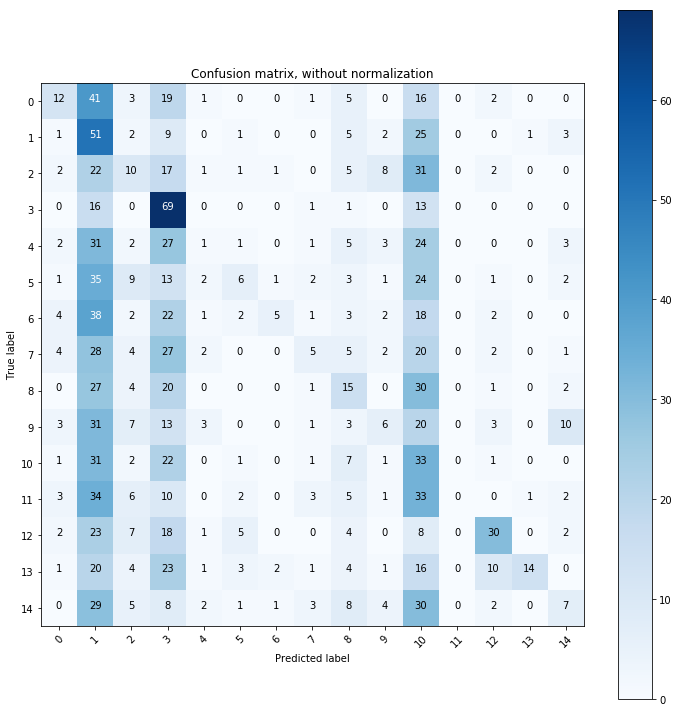

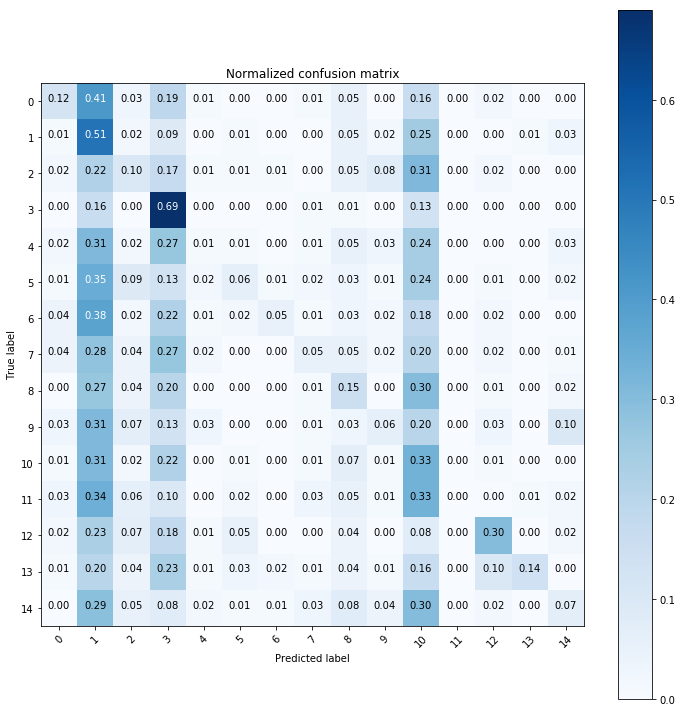

In [124]:
print_confusion_matrix(test_label, predicted_tiny_test_labels_using_train)

## Checking accuracy when test and training features is swapped:
Now, we swap the test and train data:

In [80]:
predicted_tiny_train_labels_using_test = pred_label_nn(test_feat,train_feat)
tiny_accuracy_using_test = get_accuracy(train_label, predicted_tiny_train_labels_using_test)
print "Using the test set as training and training as test"
print "The accuracy of my model using Tiny Image Representation + Nearest Neighbor Classifier is {:.2f}%".format(tiny_accuracy_using_test*100)

Using the test set as training and training as test
The accuracy of my model using Tiny Image Representation + Nearest Neighbor Classifier is 16.33%


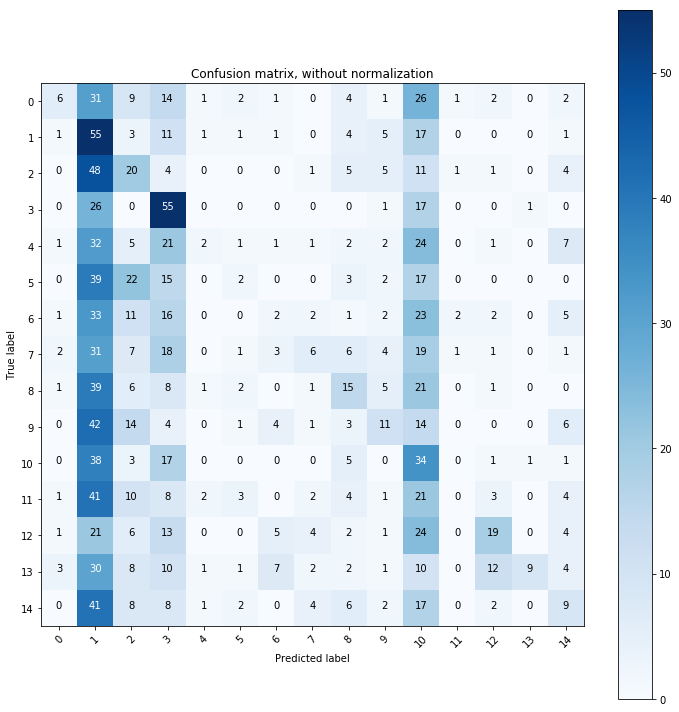

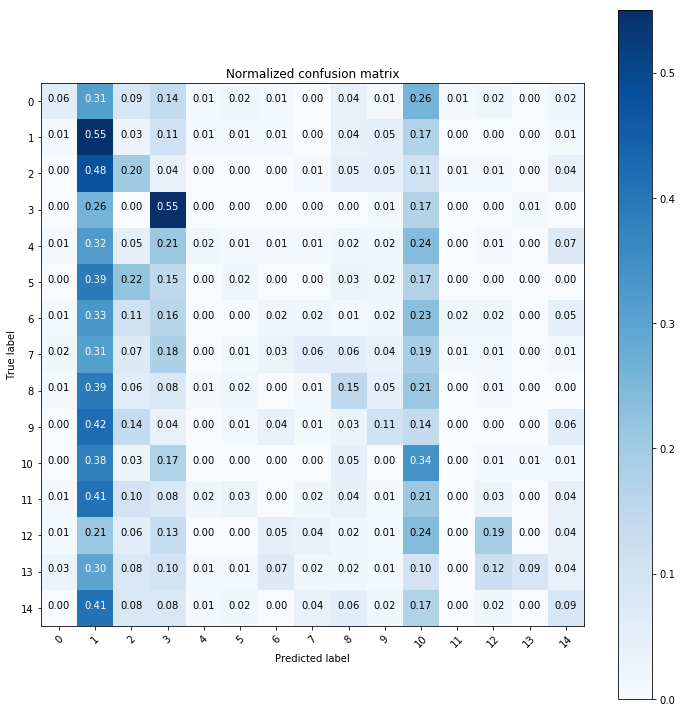

In [81]:
print_confusion_matrix(train_label, predicted_tiny_train_labels_using_test)

## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{40 points} After you have implemented a baseline scene recognition pipeline it is time to move on to a more sophisticated image representation — bags of quantized SIFT features. Before we can represent our training and testing images as bag of feature histograms, we first need to establish a vocabulary of visual words. We will form this vocabulary by sampling many local features from our training set (10's or 100's of thousands) and then cluster them with k-means. The number of k-means clusters is the size of our vocabulary and the size of our features. For example, you might start by clustering many SIFT descriptors into k=50 clusters. This partitions the continuous, 128 dimensional SIFT feature space into 50 regions. For any new SIFT feature we observe, we can figure out which region it belongs to as long as we save the centroids of our original clusters. Those centroids are our visual word vocabulary. Because it can be slow to sample and cluster many local features, the starter code saves the cluster centroids and avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of visual words. For each image we will densely sample many SIFT descriptors. Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT descriptors fall into each cluster in our visual word vocabulary. This is done by finding the nearest neighbor k-means centroid for every SIFT feature. Thus, if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT features in an image, our bag of SIFT representation will be a histogram of 50 dimensions where each bin counts how many times a SIFT descriptor was assigned to that cluster. The total of all the bin-counts is 220. The histogram should be normalized so that image size does not dramatically change the bag of features magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming, you are recommended to densely sample keypoints in a grid with certain step size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT representation (number of clusters, sampling density, sampling scales, SIFT parameters, etc.) so accuracy might vary from 50% to 60%.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [21]:
# creating SIFT
d= cv2.xfeatures2d.SIFT_create() 

## Just creating the required methods

In [22]:
#returns even keypoints for the image passed
diameter = 20 # defining what the diameter of each keypoint would be
# we put a constant diameter because variable diameters tend to give the wrong prediction 
# and also causes inconsistency

def get_keypoints(img):
    height, width = img.shape
    # here we are trying to get 8*8 = 64 sift per image
    step_w = width/8
    step_h = height/8
    allKeyPoints = []
    ranges_w = np.arange(step_w/2,width,step_w) #just getting an array of step sizes for the keypoints in width
    ranges_h = np.arange(step_h/2,height,step_h) #just getting an array of step sizes for the keypoints in height
    # all keypoints are circular here.
    #diameter = step_w if (step_w>=step_h) else step_h
    for i in ranges_w:
        for j in ranges_h:
            allKeyPoints.append(cv2.KeyPoint(i,j,diameter,-1,0,0,-1))
    return allKeyPoints

In [23]:
#function to extract SIFT Descriptors for an array of images being passed.
def extract_sift(raw_data):
    feat_dim = (len(raw_data)) # length of the array being passed
    feat = []
    for i in xrange(0,feat_dim):
        feat.append(get_descriptors(raw_data[i])) #adding individual descriptors
    return feat

# A function to extract SIFT Descriptors for an Image being passed
def get_descriptors(img):
    kp, des = d.compute(img, get_keypoints(img))
    return des

In [24]:
# 2 ways of getting histogram
# we would be using the first one because it is faster(time efficient) comparatively
# disclaimer: may not be memory efficient because we pass the kmeans itself instead of just its centroid

# function to extract array of SIFT histogram when the array of raw data of SIFT
# is passed along with clusters itself (so that we could use the predict function of kmeans)
def extract_sift_feat_hist_kmeans(raw_data, kmeans):
    feat_dim = (len(raw_data))
    feat = []
    for i in xrange(0,feat_dim):
        feat.append(get_hist_kmeans(raw_data[i], kmeans)) # get individual SIFT histograms and add
    return feat

# function to extract array of SIFT histogram when the array of raw data of SIFT 
# is passed along with cluster centroids
def extract_sift_feat_hist(raw_data, centroids):
    feat_dim = (len(raw_data))
    feat = []
    for i in xrange(0,feat_dim):
        feat.append(get_hist(raw_data[i], centroids)) # get individual SIFT histograms and add
    return feat

In [25]:
# 2 ways of getting histogram
# we would be using the first one because it is faster(time efficient) comparatively
# disclaimer: may not be memory efficient because we pass the kmeans itself instead of just its centroid

# function to extract one SIFT histogram when SIFT of 1 image 
# is passed along with clusters itself (so that we could use the predict function of kmeans)
def get_hist_kmeans(img_sift, kmeans):
    cen_size = len(kmeans.cluster_centers_) #number of clusters
    histogram = np.repeat(0,cen_size) # making the size of histogram equal to the tuple in cluster center
    for each in img_sift: # for each sift in the image
        min_index= kmeans.predict(each.reshape(1,-1)) #returns the label of the cluster it belongs to
        histogram[min_index]+=1 #recording the number of SIFTS that lie in each image
    return (histogram+0.0)/np.sum(histogram) # normalising the histogram

# function to extract one SIFT histogram when SIFT of 1 image is passed along with cluster centroids
# using the nearest neighbour technique to find which cluster the sifts belongs to
def get_hist(img_sift, centroid):
    cen_size = len(centroid) #number of clusters
    histogram = np.repeat(0,cen_size) # making the size of histogram equal to the tuple in cluster center
    for each in img_sift: #for each sift in the image
        min_val = np.sqrt(np.sum((centroid[0]-each)**2)) #getting the first value as minimum
        min_index = 0 #getting the first as minimum # dummy
        for i in range(0, cen_size): # for each centroid
            temp = np.sqrt(np.sum((centroid[i]-each)**2)) #euclidean distance of each 
            if (temp<min_val): # finding the minimum one for each image
                min_val = temp
                min_index = i
        histogram[min_index]+=1 #recording the number of SIFTS that lie in each image
    return (histogram+0.0)/np.sum(histogram) # normalising the histogram

## Now we start:

In [33]:
#here we are trying to keep a record of how much time it takes us:
time_taken_universal = 0

# Extracting SIFT descriptors features for training and test data
s = time.clock()
train_sift = extract_sift(train_data)
test_sift = extract_sift(test_data)
e = time.clock()
print "Time taken to extract SIFT descriptors from training and test data set"
print "Time: " + str(e-s)
time_taken_universal += (e-s)
print "Total time taken uptil now: " + str(time_taken_universal)

Time taken to extract SIFT descriptors from training and test data set
Time: 67.6702145201
Total time taken uptil now: 67.6702145201


In [34]:
print "We have " + str(len(train_sift)) + " training images"
print "We have " + str(len(test_sift)) + " testing images"
print "Each image has " + str(len(train_sift[0])) + " SIFT descriptors"
print "Each SIFT descriptor has " + str(len(train_sift[0][0])) + " dimensions"

We have 1500 training images
We have 1500 testing images
Each image has 64 SIFT descriptors
Each SIFT descriptor has 128 dimensions


-----
## Checking accuracy when training data is used as training and testing data is used as testing:
We will later on swap the data sets to check the accuracy

Here, we used training data for making the clusters.


In [35]:
#here we are trying to keep a record of how much time it takes us:
time_taken = 0
time_taken = time_taken_universal

In [36]:
# reshaping it from (1500,64,128) to (1500*64, 128)
# reshaping so that it is easier to send it to cluster using kmeans
all_train_sifts = np.array(train_sift).reshape(len(train_sift)*len(train_sift[0]),len(train_sift[0][0]))

In [37]:
# Clustering the training SIFTS for 100 vocabulary
s = time.clock()
kMeans_train = KMeans(n_clusters = 100, random_state = 0).fit(all_train_sifts)
e = time.clock()
print "Time taken to cluster all training SIFT descriptors"
print "Time: " + str(e-s)
time_taken += (e-s)
print "Total time taken uptil now: " + str(time_taken)

Time taken to cluster all training SIFT descriptors
Time: 464.112998717
Total time taken uptil now: 531.783213237


In [40]:
# I used kmeans.predict instead of getting the nearest neighbour from the centroid 
# because it was more time-efficient
centroids_train = kMeans_train.cluster_centers_ #shape is (100,128)

In [41]:
# here we make histogram of sifts according to the kmeans.predict from the training data
s = time.clock()
train_sift_hist_using_train = extract_sift_feat_hist_kmeans(train_sift, kMeans_train)
test_sift_hist_using_train = extract_sift_feat_hist_kmeans(test_sift, kMeans_train)
e = time.clock()
print "Time taken to make histograms of both training and test SIFT descriptors using training data clusters"
print "Time: " + str(e-s)
time_taken += (e-s)
print "Total time taken uptil now: " + str(time_taken)

Time taken to make histograms of both training and test SIFT descriptors using training data clusters
Time: 39.1410969516
Total time taken uptil now: 570.924310189


In [42]:
s = time.clock()
sift_test_labels_generated = pred_label_nn(train_sift_hist_using_train, test_sift_hist_using_train)
e = time.clock()
print "Time taken to make predict test sifts using train data using nearest neighbours"
print "Time: " + str(e-s)
time_taken += (e-s)
print "Total time taken uptil now: " + str(time_taken)

Time taken to make predict test sifts using train data using nearest neighbours
Time: 40.4309650804
Total time taken uptil now: 611.355275269


In [43]:
sift_nn_accuracy_using_train = get_accuracy(test_label, sift_test_labels_generated)
print "The accuracy of my model using Bag of SIFT Representation + Nearest Neighbor Classifier is {:.2f}%".format(sift_nn_accuracy_using_train*100)

The accuracy of my model using Bag of SIFT Representation + Nearest Neighbor Classifier is 44.80%


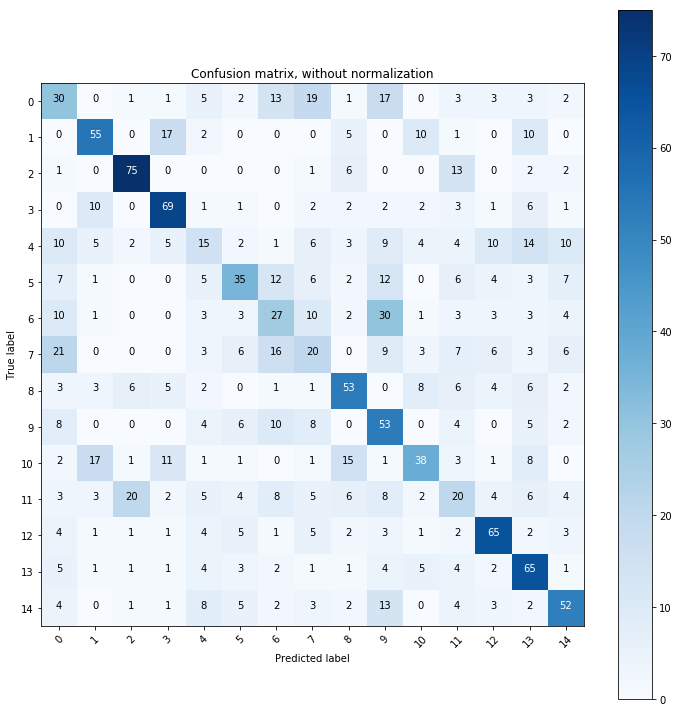

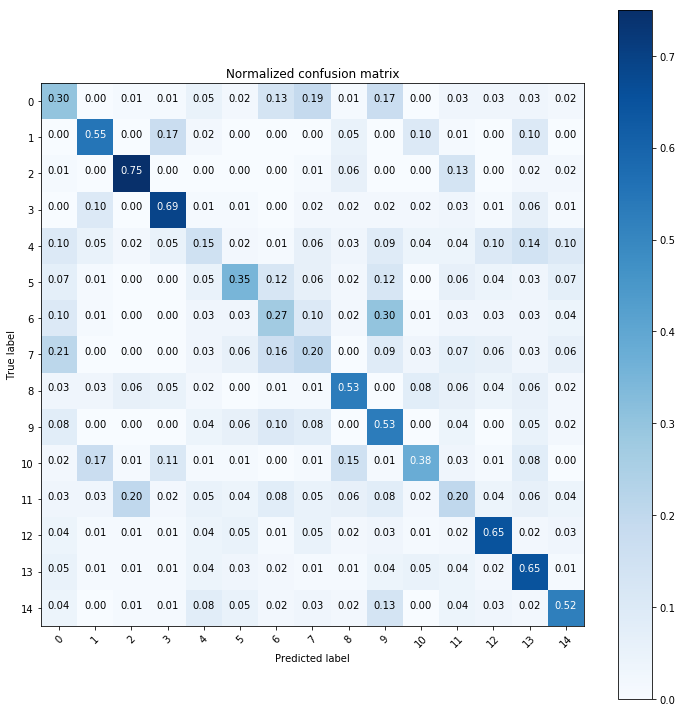

In [44]:
print_confusion_matrix(test_label, sift_test_labels_generated)

## Checking accuracy when testing data is used as training and training data is used as testing:
### Test and training data are swapped:
Now, we swap the test and train data:

Here, we used training data as test data and used test data to cluster using kmeans  and used them as training data.

In [45]:
#here we are trying to keep a record of how much time it takes us:
time_taken2 = time_taken_universal

In [46]:
# reshaping it from (1500,64,128) to (1500*64, 128)
# reshaping so that it is easier to send it to cluster using kmeans
all_test_sifts = np.array(test_sift).reshape(len(test_sift)*len(test_sift[0]),len(test_sift[0][0]))

In [47]:
# Clustering the training SIFTS for 100 vocabulary
s = time.clock()
kMeans_test = KMeans(n_clusters = 100, random_state = 0).fit(all_test_sifts)
e = time.clock()
print "Time taken to cluster all training SIFT descriptors"
print "Time: " + str(e-s)
time_taken2 += (e-s)
print "Total time taken uptil now: " + str(time_taken2)

Time taken to cluster all training SIFT descriptors
Time: 448.13426006
Total time taken uptil now: 515.80447458


In [48]:
# I used kmeans.predict instead of getting the nearest neighbour from the centroid 
# because it was more time-efficient
centroids_test = kMeans_test.cluster_centers_ #shape is (100,128)

In [49]:
# here we make histogram of sifts according to the kmeans.predict from the training data
s = time.clock()
train_sift_hist_using_test = extract_sift_feat_hist_kmeans(train_sift, kMeans_test)
test_sift_hist_using_test = extract_sift_feat_hist_kmeans(test_sift, kMeans_test)
e = time.clock()
print "Time taken to make histograms of both training and test SIFT descriptors using tseting data clusters"
print "Time: " + str(e-s)
time_taken2 += (e-s)
print "Total time taken uptil now: " + str(time_taken2)

Time taken to make histograms of both training and test SIFT descriptors using tseting data clusters
Time: 39.4459153093
Total time taken uptil now: 555.250389889


In [50]:
s = time.clock()
sift_train_labels_generated = pred_label_nn(test_sift_hist_using_test, train_sift_hist_using_test)
e = time.clock()
print "Time taken to make predict train sifts using test data using nearest neighbours"
print "Time: " + str(e-s)
time_taken2 += (e-s)
print "Total time taken uptil now: " + str(time_taken2)

Time taken to make predict train sifts using test data using nearest neighbours
Time: 48.832841259
Total time taken uptil now: 604.083231148


In [51]:
sift_nn_accuracy_using_test = get_accuracy(train_label, sift_train_labels_generated)
print "The accuracy of my model using Bag of SIFT Representation + Nearest Neighbor Classifier is {:.2f}%".format(sift_nn_accuracy_using_test*100)

The accuracy of my model using Bag of SIFT Representation + Nearest Neighbor Classifier is 43.67%


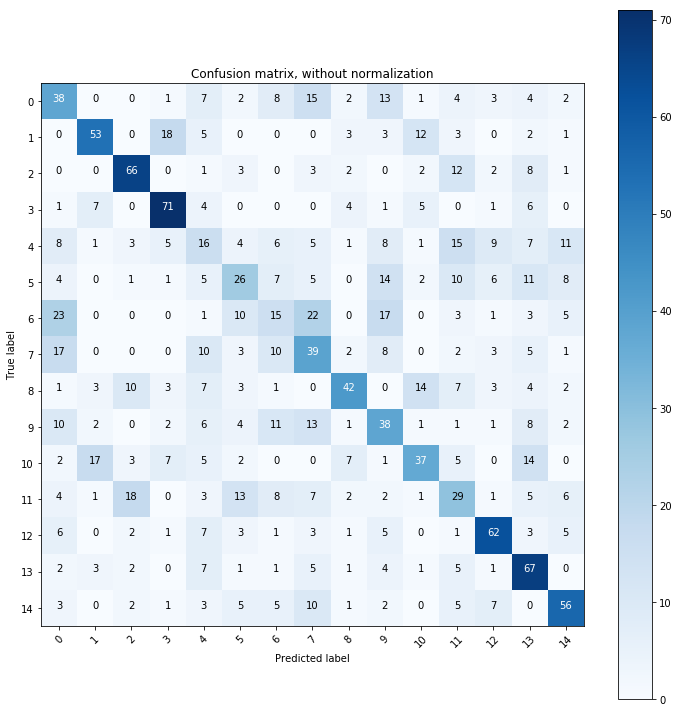

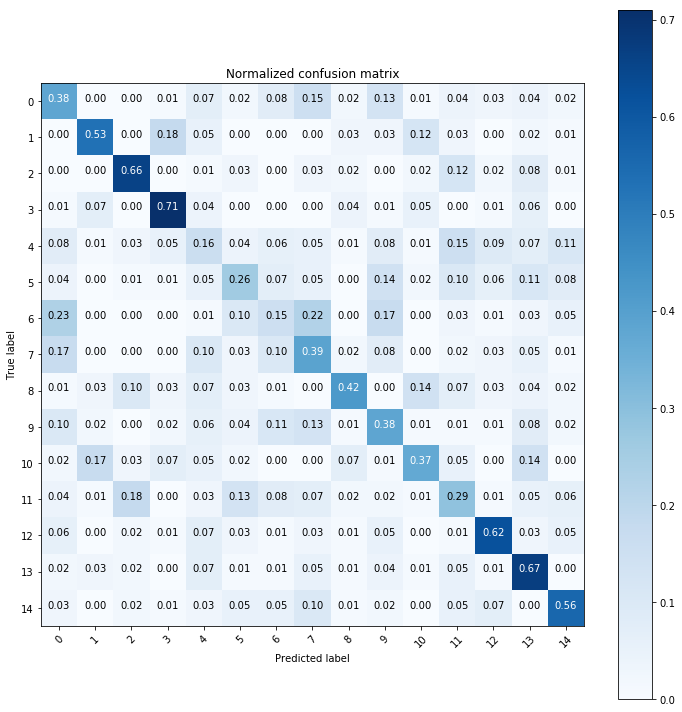

In [52]:
print_confusion_matrix(train_label, sift_train_labels_generated)

## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{15 points} The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT feature space. Linear classifiers are one of the simplest possible learning models. The feature space is partitioned by a learned hyperplane and test cases are categorized based on which side of that hyperplane they fall on. Despite this model being far less expressive than the nearest neighbor classifier, it will often perform better.

You do not have to implement the support vector machine. However, linear classifiers are inherently binary and we have a 15-way classification problem (the library has handled it for you). To decide which of 15 categories a test case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means that each classifier will be trained to recognize 'forest' vs 'non-forest', 'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each test case and the classifier which is most confidently positive "wins". E.g. if the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision boundary), and the 'forest' classifier returns a score of -0.3, and all of the other classifiers are even more negative, the test case would be classified as a kitchen even though none of the classifiers put the test case on the positive side of the decision boundary. When learning an SVM, you have a free parameter $\lambda$ (lambda) which controls how strongly regularized the model is. Your accuracy will be very sensitive to $\lambda$, so be sure to try many values.

After evaluation, compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for your final model, here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).


**Bonus Part 1 {15 points}**: One drawback of Bag of Visual Words is, all local features are encoded into a single code vector ignoring the position of the feature descriptors, which means spatial information between words are discarded in the final code vector. Thus, to incorporate the spatial information into the final code vector, one can apply Spatial Pyramid Matching, a very simple but powerful idea proposed in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf).

**Bonus Part 2 {10 points}**: Another 10 points will be given to students whose accuracy ranks top 3 in this homework. Don't cheat and don't train your model on testing data, I will run your code through with a separate testing dataset!

**Hints**:
- Use SVM in [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm) (recommended) or [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html) to do training and prediction.

## Checking accuracy: training is used as training and testing is used as testing:
We will later on swap the data sets to check the accuracy

Here, we used training data for making the clusters.


In [53]:
classify_using_train = svm.LinearSVC(C=15)
#I got the most accuracy at C = 15
train_svm = train_sift_hist_using_train
test_svm = test_sift_hist_using_train
print "Training Started..."
classify_using_train.fit(np.array(train_svm), train_label) #fitting and training
print "Training Finished..."

Training Started...
Training Finished...


In [54]:
predicted_test_labels_using_train = classify_using_train.predict(test_svm) # getting the predicted labels
SVM_accuracy_using_train = get_accuracy(test_label, predicted_test_labels_using_train) # getting the accuracy
print "The accuracy of my model using Bag of SIFT Representation + SVM is {:.2f}%".format(SVM_accuracy_using_train*100)

The accuracy of my model using Bag of SIFT Representation + SVM is 56.87%


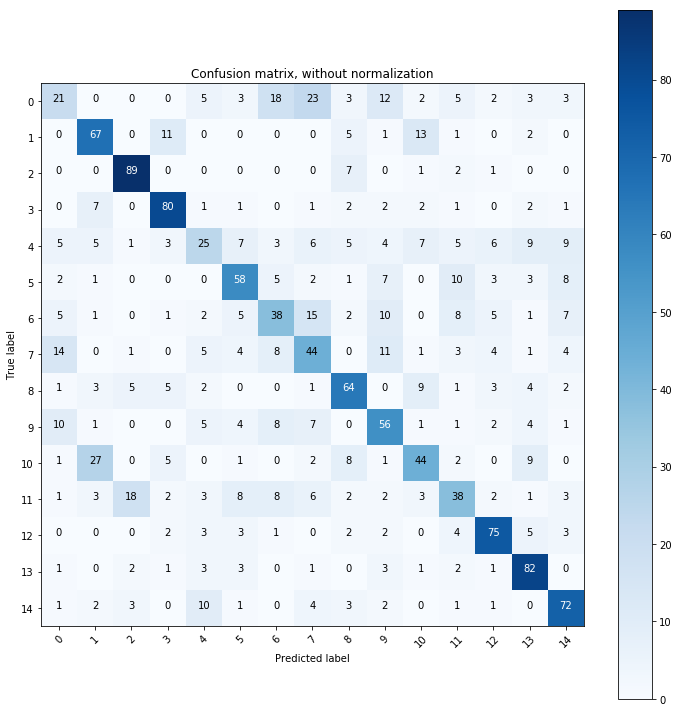

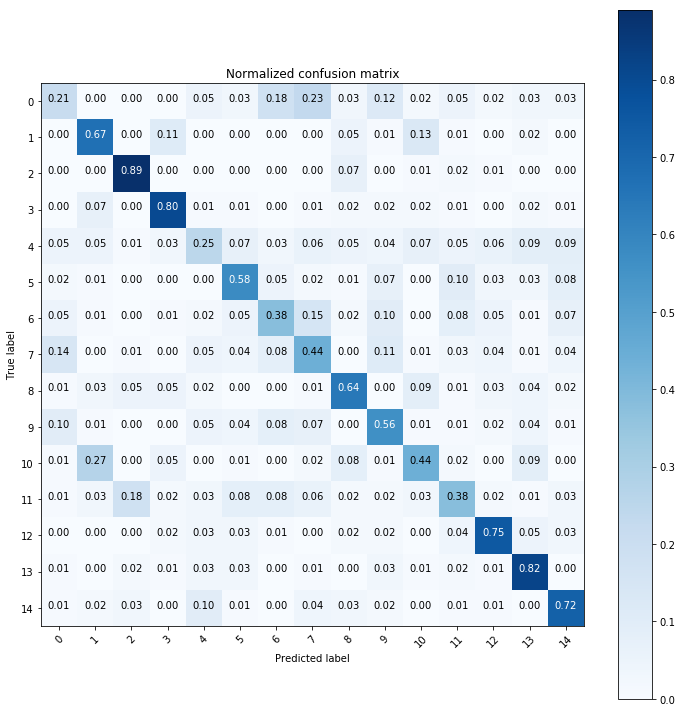

In [55]:
print_confusion_matrix(test_label, predicted_test_labels_using_train)

## Checking accuracy when testing data is used as training and training data is used as testing:
### Test and training data are swapped:

Now, we swap the test and train data:

Here, we used training data as test data and used test data to cluster using kmeans  and used them as training data.

We used test data to make clusters

In [56]:
classify_using_test = svm.LinearSVC(C=5)
#I got the most accuracy at C = 5
train_svm = test_sift_hist_using_test
test_svm = train_sift_hist_using_test
print "Training Started..."
classify_using_test.fit(np.array(train_svm), test_label) #fitting and training
print "Training Finished..."

Training Started...
Training Finished...


In [57]:
predicted_train_labels_using_test = classify_using_test.predict(test_svm) # getting the predicted labels
SVM_accuracy_using_test = get_accuracy(train_label, predicted_train_labels_using_test) # getting the accuracy
print "The accuracy of my model using Bag of SIFT Representation + SVM is {:.2f}%".format(SVM_accuracy_using_test*100)

The accuracy of my model using Bag of SIFT Representation + SVM is 56.47%


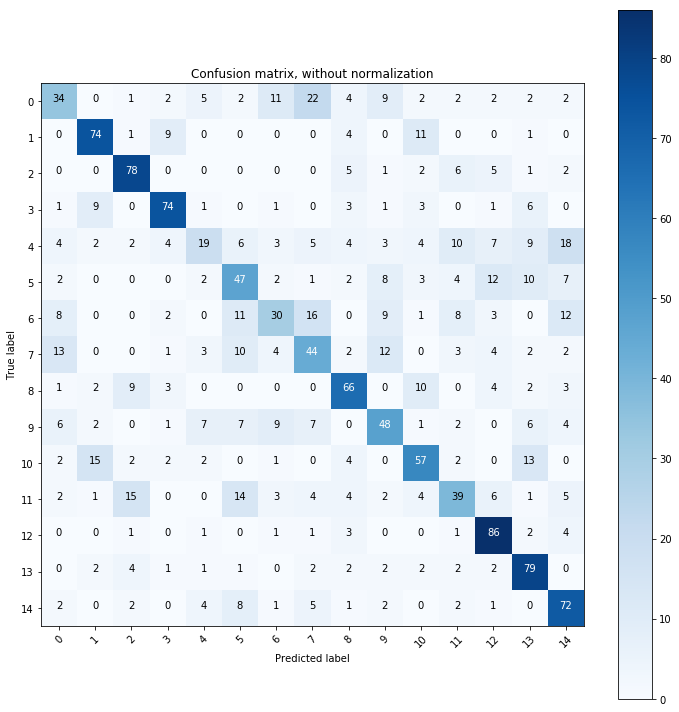

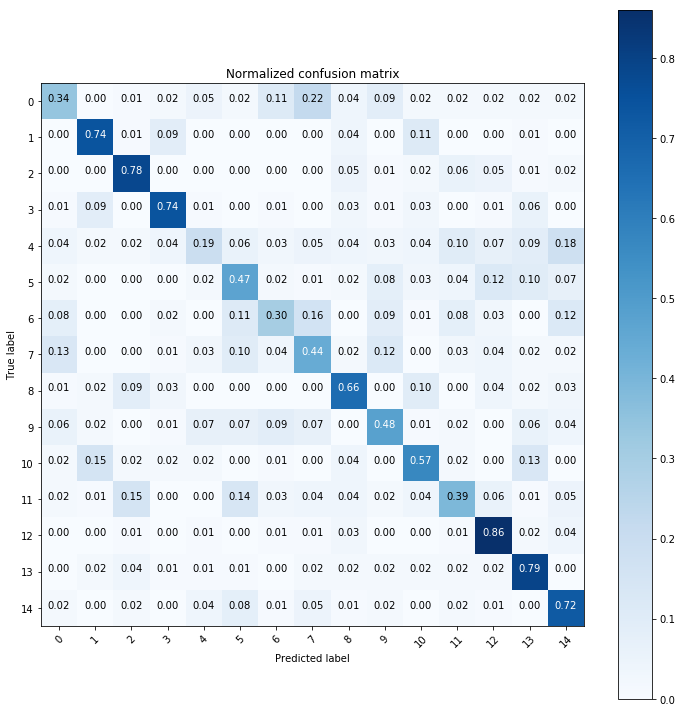

In [61]:
print_confusion_matrix(train_label, predicted_train_labels_using_test)

## Performance Report
---
{20 points} Please report the performance of different approaches you used in each problem and describe your algorithm and any decisions you made to write your algorithm in a particular way. Report the performance of your method and discuss how different choices you made affect it. Report the confusion matrix requested in problem 3, and discuss where the method performs best and worse. Discuss any extra credit you did and show what contribution it had on the results (e.g. performance with and without the extra credit component).

---
I did each of the tests twice.  First by using TRAINING_DATA as training data and TESTING_DATA as testing data. Second by using TESTING_DATA as training data and TRAINING_DATA as testing data. I did this so that I could see if we have similar accuracy with a typical combination of Representation and Classifier. Turns out it is true as both results for any combination were about 2% of each other.

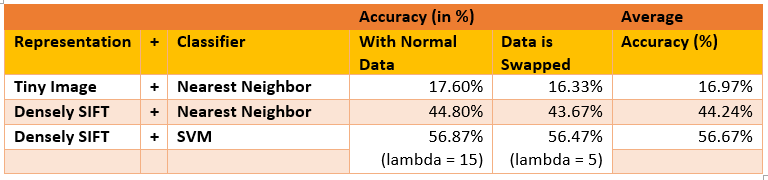

**Tiny images representation and nearest neighbor classifier  (average accuracy of about 16.97%)**

- To extract the Tiny Image representation, I just resized each image to (16,16). Then normalized each pixel by dividing it by 255. Now, I took this (16,16) image and reshaped it to a 1D array of size 16*16 = 256. Normalization increased the accuracy of the result.


- Here, I implemented my Nearest Neighbour Classifier and double-checked it with the built-in function of Scilearn and found that both of them give the same answer. However, instead of searching for which neighbour represents what label, I just keep tab of the index while going through all 1500 training data and ‘integer divide’ the index that I get with 100 because the training data was already sorted. It saves look up time for the label. Also, you don’t even have to save the training label anywhere. The only drawback is when the training data is not evenly divided.


- As seen in the confusion matrices, we see that most of the images are being classified as label 1, label 10 and label 3 respectively. It performed the best for label 3 data with an accuracy of 69% and 55%. We cannot say data of label 1 performed well even if the accuracy was high because most of the data, whether it was label 1 or not, it was being classified as label 1. So, getting a high percent might just be a conincidence.


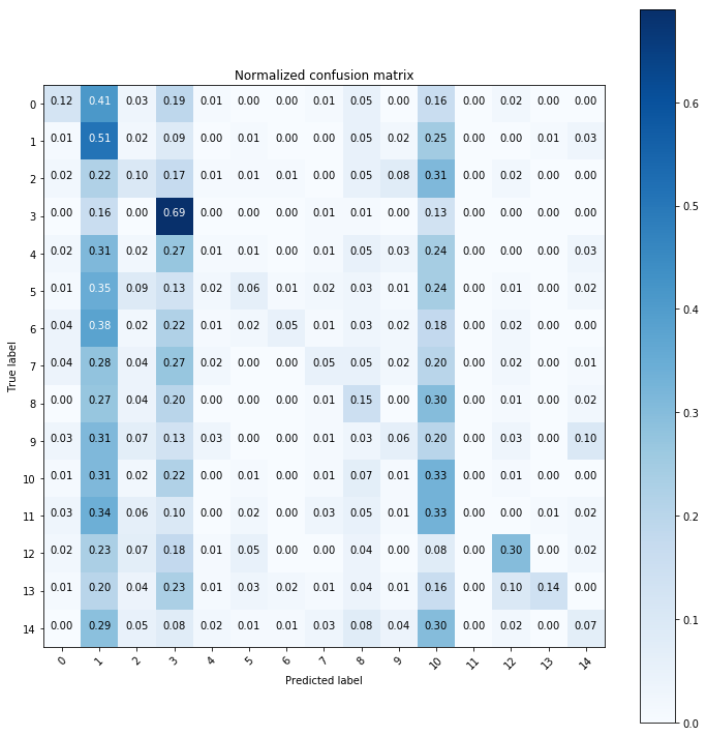

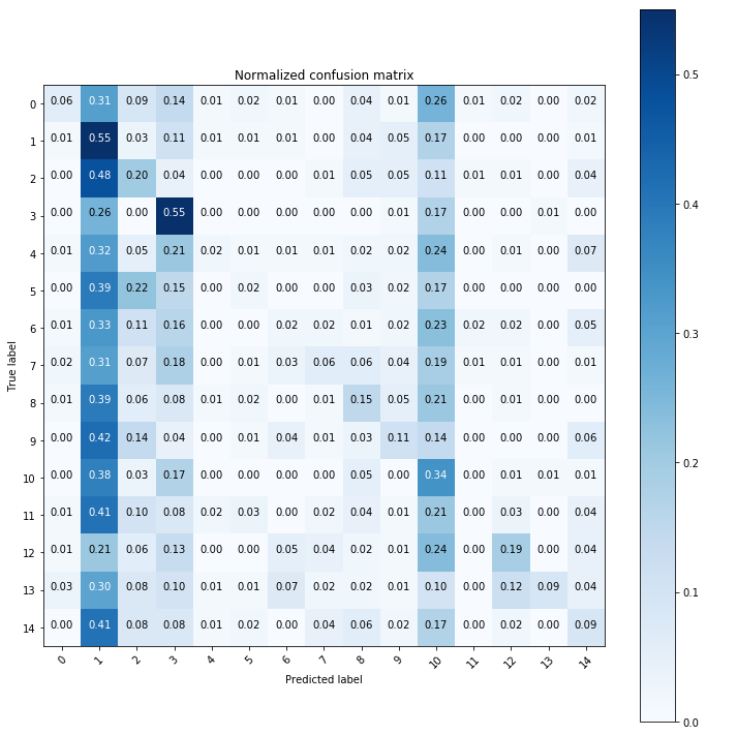

**Bag of SIFT representation and nearest neighbor classifier (average accuracy of about 44.24%)**


- As many of the tasks are repeated constantly, I moved onto more modular programming. Before I tried to resize each picture to (256,256) with predefined even 64 keypoints and diameter 32. However, this gave me a low accuracy of about 29% because firstly the most pictures weren’t square so the resizing scales differently for each image. When I did not resize, it gave me an accuracy of about 46%. When, I did not resize with a bigger diameter, it gave me an accuracy of 39%. However, the implementation was wrong as the keypoints were pre-defined. So, even though it was computationally heavier, I found different 64 evenly-spaced keypoints for each image with diameter 20. This gave me an accuracy of about 41%. I tried changing the diameter into a variable diameter which changes according to each image. But, it gave me a lower accuracy. So, I stayed with the 41% result that is different 64 evenly-spaced keypoints for each image with diameter 20.


- Also, I experimented with the number of SIFTS per image as well. However, when I did 100 SIFTS per image, it gave a lower accuracy. I think it is because when SIFTS are taken in a smaller diameter, the useful feature/identifying component either gets cropped off or becomes too small to even recognize by a SIFT feature.


- Surprisingly, when I changed my cluster size from 50 to 100, the accuracy increased to 44% from 41%. Even though it takes longer time to cluster them, once it is clustered, we don’t have to rerun kMeans every time to get a histogram for a new picture which is a good thing even if the clustering part takes long. 


- Here, I had 2 options: 

    Scenario 1 was to just use kMeans.predict() to predict which cluster each SIFTs of image lies and create the histogram. And then use Nearest neighbor to check all histograms. 

    Scenario 2 was to just use Nearest Neighbor with the Kmeans centroids to determine which cluster each SIFTs of image lies and create the histogram. And then use Nearest neighbour to check all histograms. 

    Although scenario 2 saves a lot of memory by only storing the centroids (and its id) and not worrying about any other details of kMeans, atleast in this case, scenario 2 took twice the time compared to scenario 1. So, it is better to use scenario 2 in most of the cases of big training data as kmeans gets significantly larger but for my case I used scenario 1. 
    
    
- Here, the Nearest Neighbor Classifier was the same as Part I.


- The confusion matrix shows much better accuracy Tiny+1NN (1 Nearest Neighbor). We see that atleast 5 of them in both cases are doing better than 50%.

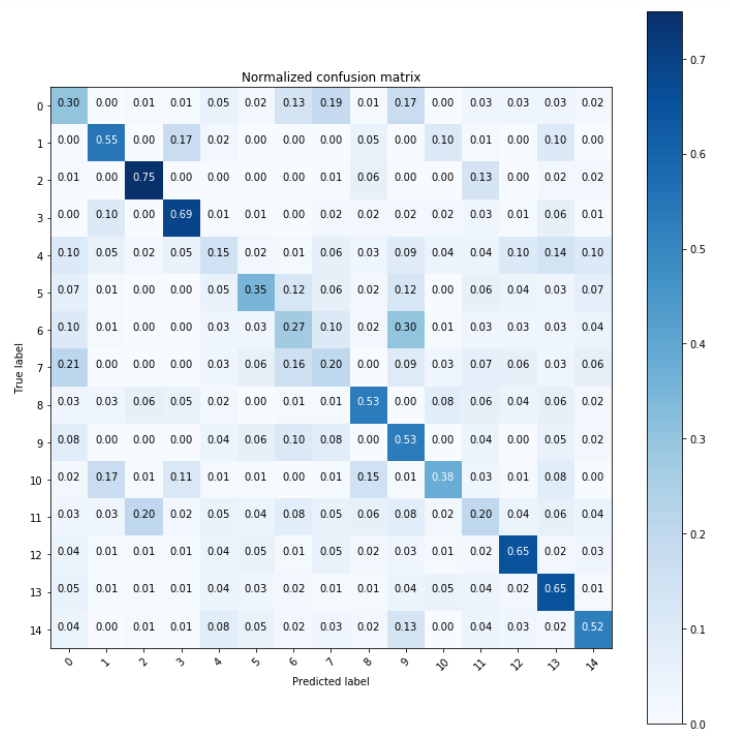

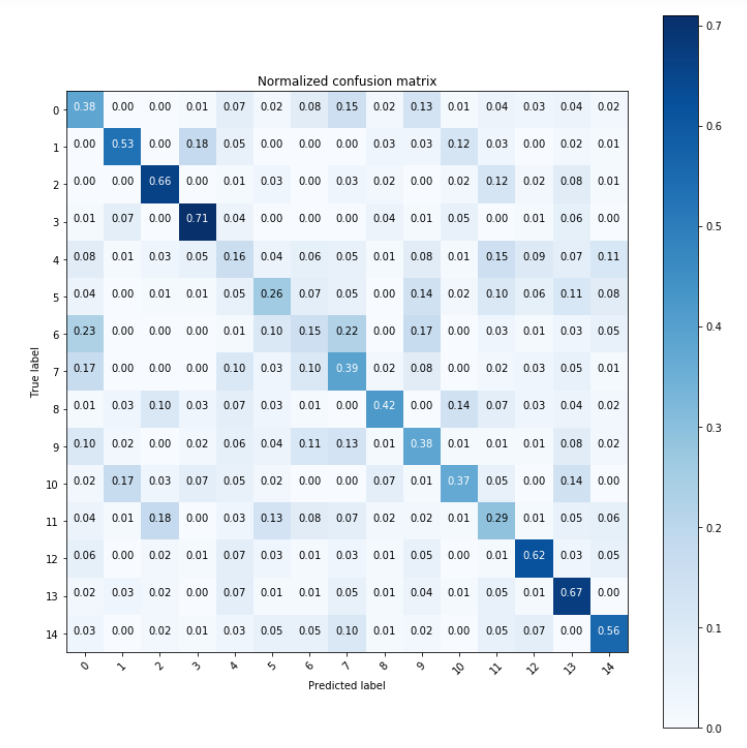

**Bag of SIFT representation and linear SVM classifier (average accuracy of about 56.67%)**

- I used a multi-class SVM because when I tried implementing 15 binary linear classifiers, the results were very skewed. 


- I used the histogram representations of SIFTS for training and test data from Part II and trained the SVM using these features. At first, I got an accuracy of only about 51-52% with the default value of the parameter $\lambda$ (lambda). But later when I changed the value of parameter $\lambda$ to about 5 to 15, I got some better results of about 56%.


- The confusion matrix shows much better accuracy SIFT+1NN (1 Nearest Neighbor). We see that atleast 8 of them in both cases are doing better than 50% and atleast 5 of them doing better than 70%.

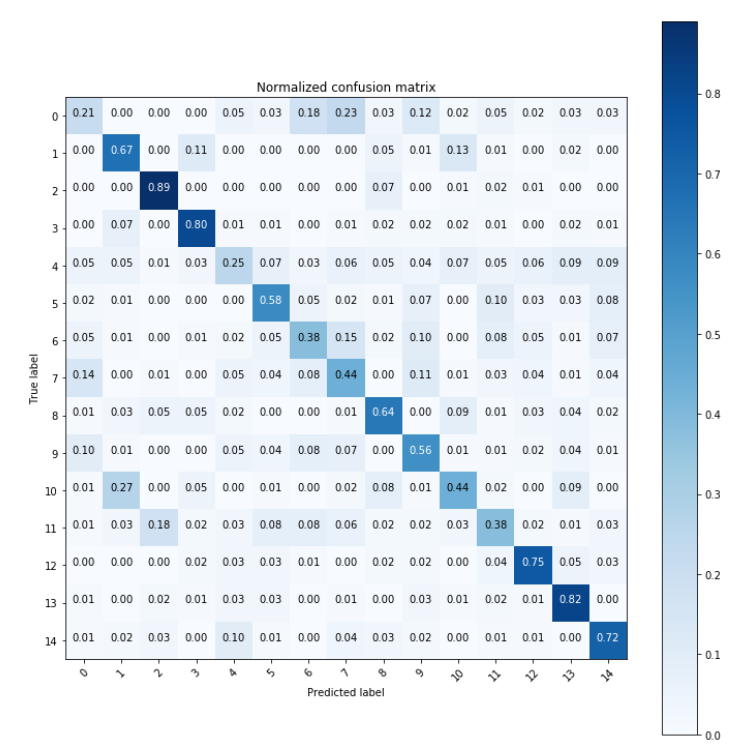

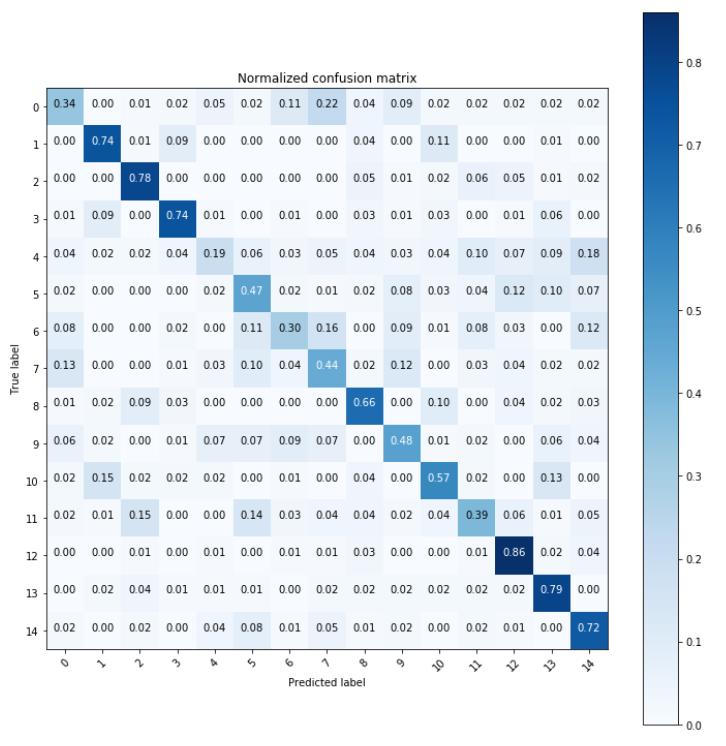

In a nutshell, predicting using 1NN takes a really long time as it compares with all training features but takes comparatively shorter time when used with a simple feature. Similarly, even if it is simple, when used with a better feature like Densely SIFT, it gives more than 30% boost in accuracy. A smart classifier like SVM takes the accuracy further up to 56%. So, depending upon the application and resources or the kind of efficiency whether it be time or size or accuracy, choosing the right combination is very important. 
**Thank you!!**